## Machine Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
# Read clean data
clean_data = pd.read_csv("data/clean_data.csv")
# Shuffle rows
clean_data = clean_data.sample(frac=1, random_state=42).reset_index(drop=True)
clean_data.head()

,Akashiwo sanguinea (cells/L),Alexandrium spp. (cells/L),Ammonia (uM),Chlorophyll (mg/m3),Dinophysis spp. (cells/L),Domoic Acid (ng/mL),Lingulodinium polyedrum (cells/L),Nitrate (uM),Nitrite (uM),Phosphate (uM),Prorocentrum spp. (cells/L),Pseudo-nitzschia delicatissima group (cells/L),Pseudo-nitzschia seriata group (cells/L),Silicate (uM),Water Temperature (C),date,Upwelling Index,ONI
0,0.000000,0.00000,0.470000,8.17,0.000000,0.000,0.000000,7.940000,0.260000,0.750000,0.000000,24550.000000,357041.0,16.250000,11.7,2013-05-24,216.0,-0.3
1,0.000000,0.00000,11.545000,1.57,8353.000000,0.000,0.000000,0.975000,0.150000,1.035000,0.000000,232.000000,2320.0,7.195000,15.0,2011-11-21,6.5,-1.1
2,937.241026,280.18417,6.191939,3.59,217.504717,0.000,968.184615,3.484584,0.417262,0.703519,4155.671795,8530.082051,2509.0,7.958344,15.7,2016-01-04,-5.0,2.5
3,0.000000,0.00000,3.120000,2.79,0.000000,0.000,0.000000,0.510000,0.337276,0.270000,0.000000,46778.000000,33784.0,1.590000,16.2,2016-03-28,318.0,1.7
4,400.000000,0.00000,0.230000,11.08,1200.000000,0.044,201200.000000,0.460000,0.040000,0.370000,30400.000000,10400.000000,1200.0,5.900000,16.9,2010-05-24,82.0,-0.1


### 1. Preprocessing

In [3]:
# Extract, transform dependent variable
target_data = (clean_data['Domoic Acid (ng/mL)'] > 0.5).astype(int)
# Extract the concentration for later use
domoic_acid = clean_data['Domoic Acid (ng/mL)']
clean_data = clean_data.drop('Domoic Acid (ng/mL)', axis=1)

From EDA, we observed seasonal differences in risk of toxic events. Let's convert the dates into seasons. We define March-May as spring, June-August as summer, September-November as fall, and December to Feburary as winter.

In [4]:
# Convert the dates into seasons
months = range(1, 13)
seasons = ['winter']*2+['spring']*3+['summer']*3+['fall']*3+['winter']
season_dict = dict(zip(months, seasons))
clean_data['date'] = pd.to_datetime(clean_data['date'])
clean_data['month'] = clean_data['date'].dt.month
clean_data['season'] = clean_data['month'].map(season_dict)
season_df = pd.get_dummies(clean_data['season'], drop_first=True)
clean_data = clean_data.drop(['date', 'month', 'season'], axis=1)

From EDA, we observed that the chemical and biological variables had skewed distribution. Log-transformation would make their distribution closer to normal. This would help models that use distances in their calculation.

In [5]:
#Log transform chemical and
cols = ['Chlorophyll (mg/m3)', 'Ammonia (uM)', 'Nitrate (uM)',
        'Nitrite (uM)', 'Phosphate (uM)', 'Silicate (uM)']
for col in cols:
    clean_data[col] = np.log(clean_data[col]+0.01)
cols = ['Akashiwo sanguinea (cells/L)', 'Alexandrium spp. (cells/L)',
        'Dinophysis spp. (cells/L)', 'Lingulodinium polyedrum (cells/L)',
        'Prorocentrum spp. (cells/L)', 'Pseudo-nitzschia delicatissima group (cells/L)',
        'Pseudo-nitzschia seriata group (cells/L)']
for col in cols:
    clean_data[col] = np.log(clean_data[col]+1)

Different columns had different scales, transforming the data so that different features have similar scale would also help models that use distances in their calculation. Though this step is not required for models such as decision trees, it wouldn't hurt either.

In [6]:
# Scale the columns
from sklearn.preprocessing import scale
scaled_data = pd.DataFrame(scale(clean_data))
scaled_data.columns = clean_data.columns
# Combine the season columns
scaled_data = pd.concat([scaled_data, season_df], axis = 1)
scaled_data.describe()

,Akashiwo sanguinea (cells/L),Alexandrium spp. (cells/L),Ammonia (uM),Chlorophyll (mg/m3),Dinophysis spp. (cells/L),Lingulodinium polyedrum (cells/L),Nitrate (uM),Nitrite (uM),Phosphate (uM),Prorocentrum spp. (cells/L),Pseudo-nitzschia delicatissima group (cells/L),Pseudo-nitzschia seriata group (cells/L),Silicate (uM),Water Temperature (C),Upwelling Index,ONI,spring,summer,winter
count,2.750000e+03,2.750000e+03,2.750000e+03,2.750000e+03,2.750000e+03,2.750000e+03,2.750000e+03,2.750000e+03,2.750000e+03,2.750000e+03,2.750000e+03,2.750000e+03,2.750000e+03,2.750000e+03,2.750000e+03,2.750000e+03,2750.000000,2750.00000,2750.000000
mean,-3.324210e-16,-1.849026e-17,-6.467554e-17,-1.177240e-16,-5.773160e-16,1.503444e-16,-2.357710e-17,-1.211152e-17,2.769502e-17,1.099726e-16,-3.936245e-17,-1.707725e-17,9.002899e-17,-7.056174e-16,6.768323e-17,1.462668e-16,0.246545,0.25200,0.238182
std,1.000182e+00,1.000182e+00,1.000182e+00,1.000182e+00,1.000182e+00,1.000182e+00,1.000182e+00,1.000182e+00,1.000182e+00,1.000182e+00,1.000182e+00,1.000182e+00,1.000182e+00,1.000182e+00,1.000182e+00,1.000182e+00,0.431078,0.43424,0.426048
min,-5.275469e-01,-4.285710e-01,-4.216546e+00,-5.573087e+00,-7.217346e-01,-7.601076e-01,-3.166774e+00,-2.836024e+00,-4.883110e+00,-1.573684e+00,-1.257900e+00,-8.515935e-01,-6.092030e+00,-2.603396e+00,-2.938961e+00,-1.839756e+00,0.000000,0.00000,0.000000
25%,-5.275469e-01,-4.285710e-01,-5.801565e-01,-6.174146e-01,-7.217346e-01,-7.601076e-01,-6.163856e-01,-5.571241e-01,-6.079309e-01,-1.573684e+00,-1.257900e+00,-8.515935e-01,-5.149173e-01,-7.223605e-01,-7.171270e-01,-6.619725e-01,0.000000,0.00000,0.000000
50%,-5.275469e-01,-4.285710e-01,4.312746e-02,-3.060585e-02,-7.217346e-01,-7.601076e-01,3.266691e-02,1.843190e-01,-5.010307e-02,3.976378e-01,4.616456e-01,-8.515935e-01,2.053492e-02,-1.111110e-01,-1.616686e-01,-2.336877e-01,0.000000,0.00000,0.000000
75%,-5.275469e-01,-4.285710e-01,5.923185e-01,6.056129e-01,1.161085e+00,1.075492e+00,7.251858e-01,5.464978e-01,5.814082e-01,7.626438e-01,8.306693e-01,1.022385e+00,5.579530e-01,5.811903e-01,5.705266e-01,5.158106e-01,0.000000,1.00000,0.000000
max,3.546959e+00,4.476267e+00,4.151053e+00,3.983199e+00,2.732573e+00,2.754864e+00,3.026917e+00,4.731333e+00,6.713031e+00,1.946297e+00,2.144924e+00,2.361351e+00,3.392303e+00,3.177320e+00,5.089939e+00,2.764306e+00,1.000000,1.00000,1.000000


In [7]:
# Create train/validation and test sets
# Use stratification to ensure similar class composition between train and test sets
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(scaled_data, target_data, stratify=target_data, random_state=42)
# Extract domoic acid concentrations for model evaluation later
da_train = domoic_acid[ytrain.index]
da_test = domoic_acid[ytest.index]

### 2. Logistic Regression

From EDA, I know the data was very imbalanced in that there were much more safe samples than dangerous samples. I am doing two things to combat this. (1) Applying oversampling with SMOTE to the training set (not the validation set). (2) Use average precision instead of accuracy or auc_roc as metric in hyperparameter tuning and model evaluation. 

In [8]:
# Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
# Create instances of models and pipeline
clf = Pipeline([('sampling', SMOTE(random_state=42)),
                ('logreg', LogisticRegression(random_state=42))])
# Grid search with cross validation
params = {
    'logreg__C': [0.001, 0.01, 0.1, 1, 10],
    'logreg__penalty': ['l1', 'l2']
}
model = GridSearchCV(clf, params, scoring='average_precision')
model.fit(Xtrain, ytrain)
print('Best parameters were', model.best_params_)
print('Best average precision was', model.best_score_)

Best parameters were {'logreg__C': 0.01, 'logreg__penalty': 'l1'}
Best average precision was 0.4408093733259946


In [9]:
# Let's check coefficients of features
logreg = Pipeline([('sampling', SMOTE(random_state=42)),
                   ('logreg', LogisticRegression(C=0.01, penalty='l1', random_state=42))])
logreg.fit(Xtrain, ytrain)
coefs = pd.Series(logreg.named_steps['logreg'].coef_.reshape(-1), index=scaled_data.columns)
print(coefs)

Akashiwo sanguinea (cells/L)                     -0.025437
Alexandrium spp. (cells/L)                        0.000000
Ammonia (uM)                                      0.006533
Chlorophyll (mg/m3)                               0.141584
Dinophysis spp. (cells/L)                         0.000000
Lingulodinium polyedrum (cells/L)                -0.056207
Nitrate (uM)                                      0.000000
Nitrite (uM)                                      0.000000
Phosphate (uM)                                    0.077456
Prorocentrum spp. (cells/L)                       0.000000
Pseudo-nitzschia delicatissima group (cells/L)    0.000000
Pseudo-nitzschia seriata group (cells/L)          1.574543
Silicate (uM)                                     0.000000
Water Temperature (C)                            -0.228550
Upwelling Index                                   0.032707
ONI                                               0.000000
spring                                            0.0000

Pseudo-nitzschia seriata was the most influential feature. Water temperature, chlorophyll were the next important features. These were consistent with EDA. However, many features had zero or near zero coefficients even we know from EDA that some of them like season had significantly impact on the risk of toxic events. This is a result of L1 regularization. Maybe a model that considers more features will perform better.

In [10]:
# Model evaluation using the test set
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, average_precision_score
def model_evaluation(model, Xtest, ytest):
    ypred = model.predict(Xtest)
    ypred_prob = model.predict_proba(Xtest)[:,1]
    print('Accuracy of test set was', accuracy_score(ytest, ypred))
    print('Average precision of test set was', average_precision_score(ytest, ypred_prob))
    print("\n")
    tn, fp, fn, tp = confusion_matrix(ytest, ypred).ravel()
    print('True Negative = {}\tFalse Positive = {}\nFalse Negative = {}\tTrue Positive={}'
          .format(tn,fp,fn,tp))
    print("\n")
    print(classification_report(ytest, ypred))
model_evaluation(logreg, Xtest, ytest)

Accuracy of test set was 0.7456395348837209
Average precision of test set was 0.3421144752653311


True Negative = 486	False Positive = 173
False Negative = 2	True Positive=27


             precision    recall  f1-score   support

          0       1.00      0.74      0.85       659
          1       0.14      0.93      0.24        29

avg / total       0.96      0.75      0.82       688



The main problem here is low precision for the positive class, in other words, too many false positives.

### 3. Support Vector Machine

In [11]:
# Import libraries
from sklearn.svm import SVC
# Create instances of models and pipeline
clf = Pipeline([('sampling', SMOTE(random_state=42)),
                ('svm', SVC(probability=True, random_state=42))])
# Grid search with cross validation
params = {
    'svm__C': [0.1, 1, 10, 100, 1000, 10000],
    'svm__gamma': [1e-4, 0.001, 0.01, 0.1, 1, 10]
}
model = GridSearchCV(clf, params, scoring='average_precision', n_jobs=-1)
model.fit(Xtrain, ytrain)
print('Best parameters were', model.best_params_)
print('Best average precision was', model.best_score_)

Best parameters were {'svm__C': 1000, 'svm__gamma': 0.001}
Best average precision was 0.4526853932156869


In [12]:
# Model evaluation
svc = Pipeline([('sampling', SMOTE(random_state=42)),
                ('svm', SVC(C=1000, gamma=0.001, probability=True, random_state=42))])
svc.fit(Xtrain, ytrain)
model_evaluation(svc, Xtest, ytest)

Accuracy of test set was 0.9055232558139535
Average precision of test set was 0.33742437177976414


True Negative = 603	False Positive = 56
False Negative = 9	True Positive=20


             precision    recall  f1-score   support

          0       0.99      0.92      0.95       659
          1       0.26      0.69      0.38        29

avg / total       0.95      0.91      0.92       688



The accuracy improved a lot, but average precision was similar to logistic regression. This model drastically improved the precision for the positive class at the cost of recall. F1 score was better though.

### 4. Random Forest

In [13]:
# Import libraries
from sklearn.ensemble import RandomForestClassifier
# Create instances of models and pipeline
clf = Pipeline([('sampling', SMOTE(random_state=42)),
                ('rf', RandomForestClassifier(random_state=42))])
# Grid search with cross validation
params = {
    'rf__n_estimators': [10, 50, 100, 200],
    'rf__max_depth': [10, 20, None],
    'rf__min_samples_split': [2, 10, 20, 50],
    'rf__min_samples_leaf': [1, 5, 10, 20]
}
model = GridSearchCV(clf, params, scoring='average_precision', n_jobs=-1)
model.fit(Xtrain, ytrain)
print('Best parameters were', model.best_params_)
print('Best average precision was', model.best_score_)

Best parameters were {'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
Best average precision was 0.4842581052682777


In [14]:
#Model evaluation
rf = Pipeline([('sampling', SMOTE(random_state=42)),
               ('rf', RandomForestClassifier(
                   n_estimators=200, max_depth=None, min_samples_split=2,
                   min_samples_leaf=1, random_state=42)
               )])
rf.fit(Xtrain, ytrain)
model_evaluation(rf, Xtest, ytest)

Accuracy of test set was 0.9651162790697675
Average precision of test set was 0.49777010217302897


True Negative = 644	False Positive = 15
False Negative = 9	True Positive=20


             precision    recall  f1-score   support

          0       0.99      0.98      0.98       659
          1       0.57      0.69      0.62        29

avg / total       0.97      0.97      0.97       688



This model's overall performance was even better than SVC. It had better average precision, higher precision with the same recall.

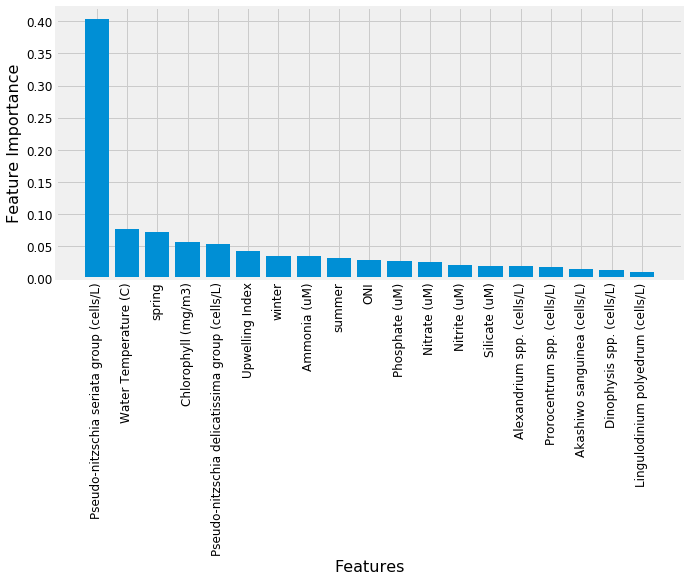

In [15]:
# Let's take a look at feature importance
imp = pd.Series(rf.named_steps['rf'].feature_importances_, index=scaled_data.columns)
imp = imp.sort_values(ascending=False)
def plot_importance(importance):
    importance = importance.sort_values(ascending = False)
    plt.figure(figsize=(10,5))
    _ = plt.bar(range(len(importance)), importance)
    _ = plt.xticks(range(len(importance)), importance.index, rotation=90)
    _ = plt.xlabel('Features', fontsize=16)
    _ = plt.ylabel("Feature Importance", fontsize=16)
    _ = plt.xticks(fontsize=12)
    _ = plt.yticks(fontsize=12)
plot_importance(imp)

The most important feature was the same as logistic regression model. After that, water temperature, chlorophyll, season were the next most important. This model considers more features than logistic regression. That's probably why it performs better.

### 5. Gradient Boost

In [16]:
from sklearn.ensemble import GradientBoostingClassifier
# Use some tuned parameters from random forest, only tune learning rate and n_estimators
clf = Pipeline([('sampling', SMOTE(random_state=42)),
                ('gb', GradientBoostingClassifier(
                    min_samples_split=2, min_samples_leaf=1, max_depth=None,
                    max_features='sqrt', random_state=42)
                )]) # Change max_features to sqrt, default is None
params = {
    'gb__learning_rate': [0.05, 0.1, 0.15, 0.2],
    'gb__n_estimators': [25, 50, 100, 200],
}
model = GridSearchCV(clf, params, scoring='average_precision', n_jobs=-1)
model.fit(Xtrain, ytrain)
print('Best parameters were', model.best_params_)
print('Best average precision was', model.best_score_)

Best parameters were {'gb__learning_rate': 0.1, 'gb__n_estimators': 50}
Best average precision was 0.4969503872972618


In [17]:
# Model evaluation
gb = Pipeline([('sampling', SMOTE(random_state=42)),
               ('gb', GradientBoostingClassifier(
                   min_samples_split=2, min_samples_leaf=1, max_depth=None,
                   max_features='sqrt',learning_rate=0.1, n_estimators=50, random_state=42)
               )])
gb.fit(Xtrain, ytrain)
model_evaluation(gb, Xtest, ytest)

Accuracy of test set was 0.9665697674418605
Average precision of test set was 0.5218017075616157


True Negative = 647	False Positive = 12
False Negative = 11	True Positive=18


             precision    recall  f1-score   support

          0       0.98      0.98      0.98       659
          1       0.60      0.62      0.61        29

avg / total       0.97      0.97      0.97       688



This model performed similarly if not slightly better than the random forest model, with slightly higher precision and slightly lower recall. Average precision was slightly higher.

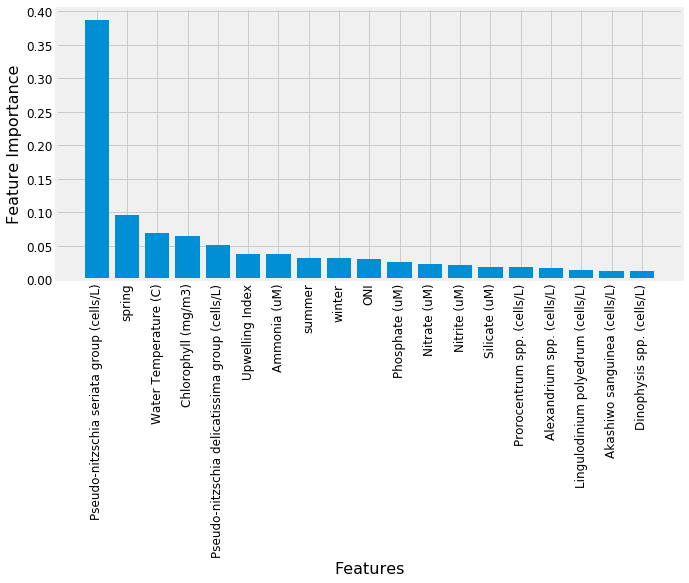

In [18]:
# Let's take a look at feature importance
imp = pd.Series(gb.named_steps['gb'].feature_importances_, index=scaled_data.columns)
imp = imp.sort_values(ascending=False)
plot_importance(imp)

Feature importances were also very similar to random forest model.

These models all had their strengths and weaknesses. Logistic regression model had the best recall while the other three models had better precision. Also, different models considered features differently. Combining them as an ensemble model would probably do better than each individually.

### 6. Ensemble model

In [19]:
from sklearn.ensemble import VotingClassifier
# Make a weights matrix
weights = [[int(x) for x in list("{0:0b}".format(i).zfill(4))] for i in range(1, 2**4)]
print('Weights matrix is', weights)
# Use CV to figure which models to use in the ensumble model
clf = VotingClassifier(
    estimators=[('logreg', logreg), ('svc', svc), ('rf', rf), ('gb', gb)],
    voting='soft')
params = {'weights': weights}
model = GridSearchCV(clf, params, scoring='average_precision', n_jobs=-1)
model.fit(Xtrain, ytrain)
print('Best parameters were', model.best_params_)
print('Best average precision was', model.best_score_)

Weights matrix is [[0, 0, 0, 1], [0, 0, 1, 0], [0, 0, 1, 1], [0, 1, 0, 0], [0, 1, 0, 1], [0, 1, 1, 0], [0, 1, 1, 1], [1, 0, 0, 0], [1, 0, 0, 1], [1, 0, 1, 0], [1, 0, 1, 1], [1, 1, 0, 0], [1, 1, 0, 1], [1, 1, 1, 0], [1, 1, 1, 1]]
Best parameters were {'weights': [1, 0, 0, 1]}
Best average precision was 0.5566657248192033


In [20]:
# CV suggests that we should use only logistic regression and gradient boosting.
# Try a few different weights between the three classifiers
clf = VotingClassifier(estimators=[('logreg', logreg), ('gb', gb)], voting='soft')
params = {'weights': [[1,1], [2,1], [1,2], [1.5,1], [1,1.5]]}
model = GridSearchCV(clf, params, scoring='average_precision', n_jobs=-1)
model.fit(Xtrain, ytrain)
print('Best parameters were', model.best_params_)
print('Best average precision was', model.best_score_)

Best parameters were {'weights': [1, 1]}
Best average precision was 0.5566657248192033


In [21]:
# Use the best weights parameter
voting = VotingClassifier(
    estimators=[('logreg', logreg), ('gb', gb)],
    voting='soft', weights = [1,1])
voting.fit(Xtrain, ytrain)
model_evaluation(voting, Xtest, ytest)

Accuracy of test set was 0.9607558139534884
Average precision of test set was 0.527174436607178


True Negative = 639	False Positive = 20
False Negative = 7	True Positive=22


             precision    recall  f1-score   support

          0       0.99      0.97      0.98       659
          1       0.52      0.76      0.62        29

avg / total       0.97      0.96      0.96       688



/Users/zhenfengliu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Let's compare with the best indivual model, the gradient boosting model. Average precision was higher in the voting model. It had higher recall, slightly lower precision, and similar F1 score.<br>
But it is hard to evalute these models just by looking at the scores, let's plot the precision-recall curve of all models and see which is best.

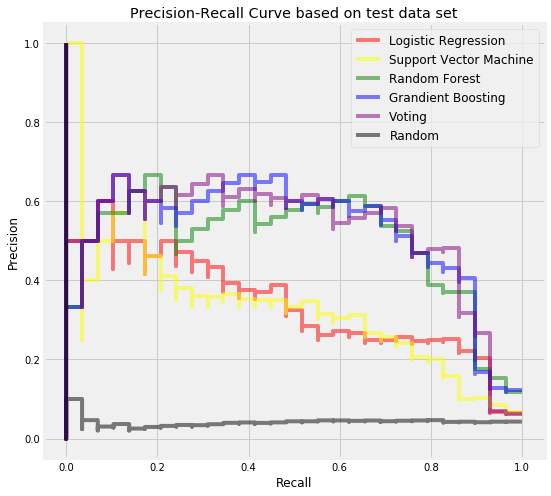

In [22]:
# Plot the precision-recall curve of different models on the test set.
from sklearn.metrics import precision_recall_curve
models = [logreg, svc, rf, gb, voting]
labels = ['Logistic Regression', 'Support Vector Machine',
          'Random Forest', 'Grandient Boosting', 'Voting']
colors = ['red', 'yellow', 'green', 'blue', 'purple']
plt.figure(figsize=(8,8))
for index, model in enumerate(models):
    model.fit(Xtrain, ytrain)
    ypred_prob = model.predict_proba(Xtest)[:,1]
    precision, recall, _ = precision_recall_curve(ytest, ypred_prob)
    _ = plt.step(recall, precision, color=colors[index], alpha=0.5, where='post', label=labels[index])
random = np.random.rand(len(ytest))
precision, recall, _ = precision_recall_curve(ytest, random)
_ = plt.step(recall, precision, color='k', alpha=0.5, where='post', label='Random')
_ = plt.xlabel('Recall')
_ = plt.ylabel('Precision')
_ = plt.legend(fontsize=12, bbox_to_anchor=(1, 1))
_ = plt.title('Precision-Recall Curve based on test data set')

It was clear from this plot that the tree based models and the voting model are much better than logistic regression and support vector machine. It seemed that voting model was a little better than random forest and gradient boosting, especially when higher recall was required. <br>
Let's see how the model performs with real domoic acid concentrations, not just a binary classification.

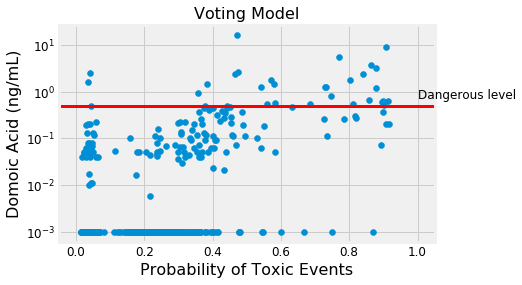

In [23]:
#Plot probability against domoic acid value, based on test set.
def plot_prob_value(value, model, Xtest, title):
    ypred_prob = model.predict_proba(Xtest)[:,1]
    plt.yscale('log')
    _ = plt.scatter(ypred_prob, value)
    _ = plt.xlabel('Probability of Toxic Events', fontsize=16)
    _ = plt.ylabel('Domoic Acid (ng/mL)', fontsize=16)
    _ = plt.axhline(y=0.5, color='r', lw=3)
    _ = plt.text(1, 0.7, 'Dangerous level', fontsize=12)
    _ = plt.xlim([-0.05,1.05])
    _ = plt.xticks(fontsize=12)
    _ = plt.yticks(fontsize=12)
    _ = plt.title(title, fontsize=16)
plot_prob_value(da_test+0.001, voting, Xtest, 'Voting Model')

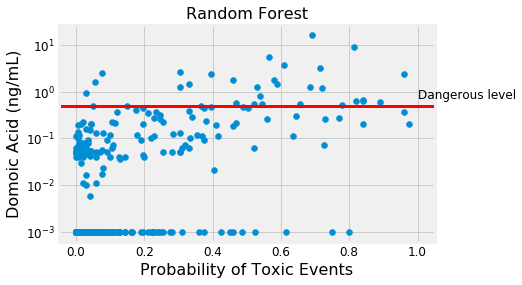

In [24]:
# Plot a single model to compare
plot_prob_value(da_test+0.001, rf, Xtest, 'Random Forest')

We can see the voting model had higher recall, with most dangerous samples having probabilities of ~0.4 or higher. On the other hand, the random forest model had higher precision.<br>
Let's think about the two models practically. A false positive prediction would probably result in some wasted resources such as unnecessary domoic acid tests, and/or some extra caution such as limited fishing, swimming, etc. The consequences are mostly economic. A false negative prediction, on the other hand, could potentially have catastrophic consequences, such as public health crisis. **Therefore, from a practical point of view, we want a model with higher recall at the cost of precision. I would conclude the voting model is the most useful from the ones tested here**. 